## 샘플 데이터셋 로드


In [1]:
!pip install opendata-kr -q
from opendata import dataset

dataset.download('toydata')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.3 MB/s eta 0:00:00
======= 다운로드 시작 =======

data/toydata/toy-datasets.zip


  0%|          | 0.00/1.33M [00:00<?, ?B/s]

압축 해제 및 프로젝트 파일 구성중...

======= 다운로드 완료 =======


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import torch

warnings.filterwarnings("ignore")

In [3]:
# 보스톤 주택 가격 데이터셋 로드
df = pd.read_csv("data/toydata/boston_house_price.csv")
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


**컬럼 소개**

속성 수 : 13

- **CRIM**: 자치시 별 범죄율
- **ZN**: 25,000 평방 피트를 초과하는 주거용 토지의 비율
- **INDUS**: 비소매(non-retail) 비즈니스 토지 비율
- **CHAS**: 찰스 강과 인접한 경우에 대한 더비 변수 (1= 인접, 0= 인접하지 않음)
- **NOX**: 산화 질소 농도 (10ppm)
- **RM**:주택당 평균 객실 수
- **AGE**: 1940 년 이전에 건축된 자가소유 점유 비율
- **DIS**: 5 개의 보스턴 고용 센터까지의 가중 거리
- **RAD**: 고속도로 접근성 지수
- **TAX**: 10,000 달러 당 전체 가치 재산 세율
- **PTRATIO** 도시별 학생-교사 비율
- **B**: 인구당 흑인의 비율. 1000(Bk - 0.63)^2, (Bk는 흑인의 비율을 뜻함)
- **LSTAT**: 하위 계층의 비율
- **PRICE**: 자가 주택의 중앙값 (1,000 달러 단위)


In [4]:
# feature(x), label(y)로 분할
x = df.drop("PRICE", axis=1)
y = df["PRICE"]

# feature 변수의 개수 지정
NUM_FEATURES = len(x.columns)

In [14]:
# feature 변수의 개수 지정
NUM_FEATURES = len(df.drop("PRICE", axis=1).columns)
print(f"number of features: {NUM_FEATURES}")


number of features: 13


13

## 서브클래싱으로 CustomDataset 생성

- SubClassing으로 Dataset을 상속받아 구현하게 되면 DataLoader에 주입하여 배치(batch) 구성을 쉽게 할 수 있습니다.
- 보통 `__init__()` 함수에서 데이터를 set 해주게 되고, 기타 필요한 전처리를 수행합니다. Image Transformation은 `__getitem__(self, idx)`에서 구현하는 경우도 있습니다.
- SubClassing으로 커스텀 Dataset을 구성한다면 `__len__(self)`함수와 `__getitem__(self, idx)`를 구현해야 합니다.
- [참고: 파이토치 튜토리얼(Tutorials > Dataset과 DataLoader)](https://tutorials.pytorch.kr/beginner/basics/data_tutorial.html)


In [6]:
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler


class CustomDataset(Dataset):
    def __init__(self, data, target="target", normalize=True):
        super(CustomDataset, self).__init__()
        self.x = data.drop(target, axis=1)

        # 데이터 표준화
        if normalize:
            scaler = StandardScaler()
            self.x = pd.DataFrame(scaler.fit_transform(self.x))

        self.y = data[target]

        # 텐서 변환
        self.x = torch.tensor(self.x.values).float()
        self.y = torch.tensor(self.y).float()
# 데이터의 행 수를 반환
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        x = self.x[idx]
        y = self.y[idx]
        return x, y
#__len__ 메소드는 데이터세트의 길이를 제공하고,
#__getitem__ 메소드는 데이터세트에서 개별 샘플을 인덱싱하고 검색하는 것을 허용합니다.
#이를 통해 데이터 세트를 반복하고 훈련 또는 평가 중에 샘플에 액세스할 수 있습니다.

In [7]:
# Custom으로 정의한 데이터셋 생성
dataset = CustomDataset(df, "PRICE", True)

Custom으로 정의한 데이터셋은 `torch.utils.data.DataLoader`에 주입할 수 있습니다.


In [8]:
from torch.utils.data import DataLoader

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [9]:
x, y = next(iter(data_loader))
#x, y = next(iter(data_loader))는 next()에 의해 반환된 튜플을 x와 y라는 두 개의 변수로 압축 해제합니다.
#x에는 배치에 대한 입력 특성이 포함되고, y에는 해당 라벨이 포함됩니다.


In [10]:
x.shape, y.shape

(torch.Size([32, 13]), torch.Size([32]))

## PyTorch를 활용하여 회귀(regression) 예측


In [11]:
# Device 설정 (cuda:0 혹은 cpu)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self, num_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(num_features, 32)
        self.fc2 = nn.Linear(32, 8)
        # 마지막 출력층의 Neuron은 1개로 설정
        self.output = nn.Linear(8, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.output(x)
        return x

In [13]:
# 모델 생성
model = Net(NUM_FEATURES)
# 모델을 device 에 올립니다. (cuda:0 혹은 cpu)
model.to(device)
model

Net(
  (fc1): Linear(in_features=13, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
)

## 손실함수(Loss Function) / 옵티마이저(Optimzier) 정의


In [15]:
# Mean Squared Error(MSE) 오차 정의
loss_fn = nn.MSELoss()

In [16]:
model.parameters()

<generator object Module.parameters at 0x7900b22a10e0>

In [17]:
# 옵티마이저 설정: model.paramters()와 learning_rate 설정
# 지금까지 경사하강법 서서 업데이트 SGD
# ADAM은 경사하강법에 모멘텀을 추가! 조금 더 성능이 개선 된 알고리즘이다
# 업데이트할 뉴런을 지정해준다 model.parameteres(뉴런들), lr은 learning rate

optimizer = optim.Adam(model.parameters(), lr=0.005)

## 경사하강법을 활용한 회귀 예측


In [18]:
# 여기 내용은 템플릿화 해서 붙여넣기 해야한다!!!

# 최대 반복 횟수 정의
num_epoch = 200

# loss 기록하기 위한 list 정의 loss가 변하는 지를 모니터링 하는거다
losses = []

for epoch in range(num_epoch):
    # loss 초기화
    # 매 번 loss 계산
    running_loss = 0
    for x, y in data_loader:
        # x, y 데이터를 device 에 올립니다. (cuda:0 혹은 cpu) 올려야 GPU로 학습 모델을 올리면 데이터도 gpu에 올려야 하기 때문
        x = x.to(device)
        y = y.to(device)

        # 그라디언트 초기화 (초기화를 수행하지 않으면 계산된 그라디언트는 누적됩니다.)
        # 초기값을 0으로 세팅해준다 초기화 하지 않으면 이전의 값이 그대로 남아 있는다
        optimizer.zero_grad()

        # output 계산: model의 __call__() 함수 호출
        # __call__은 forward(순전파) 호출한다
        # 결과가 나왔다
        y_hat = model(x)

        # 실제값이랑 비교 해서 손실(loss) 계산
        loss = loss_fn(y.view(-1, 1), y_hat)
        # view?
        # view는 tensor의 shape 변환은 차원을 추가 y_hat이 32,1이기 때문이다
        # view 안 해도 되는데 제대로 안 나올 때도 있다. 그래서 그냥 하자

        # 미분 계산 = 자 이정도 차이가 나더라 조정해라
        loss.backward()

        # 경사하강법 계산 및 적용, 실제로 노드에 차감해서 갱신해라!
        optimizer.step()

        # 배치별 loss 를 누적합산 합니다.
        running_loss += loss.item()

    # 누적합산된 배치별 loss값을 배치의 개수로 나누어 Epoch당 loss를 산출합니다.
    # 한 배치당 평균 로스!!
    loss = running_loss / len(data_loader)
    losses.append(loss)

    # 20번의 Epcoh당 출력합니다.
    if epoch % 20 == 0:
        print("{0:05d} loss = {1:.5f}".format(epoch, loss))

print("----" * 15)
print("{0:05d} loss = {1:.5f}".format(epoch, loss))

00000 loss = 566.16301
00020 loss = 12.71033
00040 loss = 9.85089
00060 loss = 8.57020
00080 loss = 8.07294
00100 loss = 7.80225
00120 loss = 7.20505
00140 loss = 7.46057
00160 loss = 6.53599
00180 loss = 6.54483
------------------------------------------------------------
00199 loss = 6.21317


In [19]:
loss
# 텐서에서 그 값을 뽑아낼 때 쓴다 그 숫자 값만!!

6.21316759288311

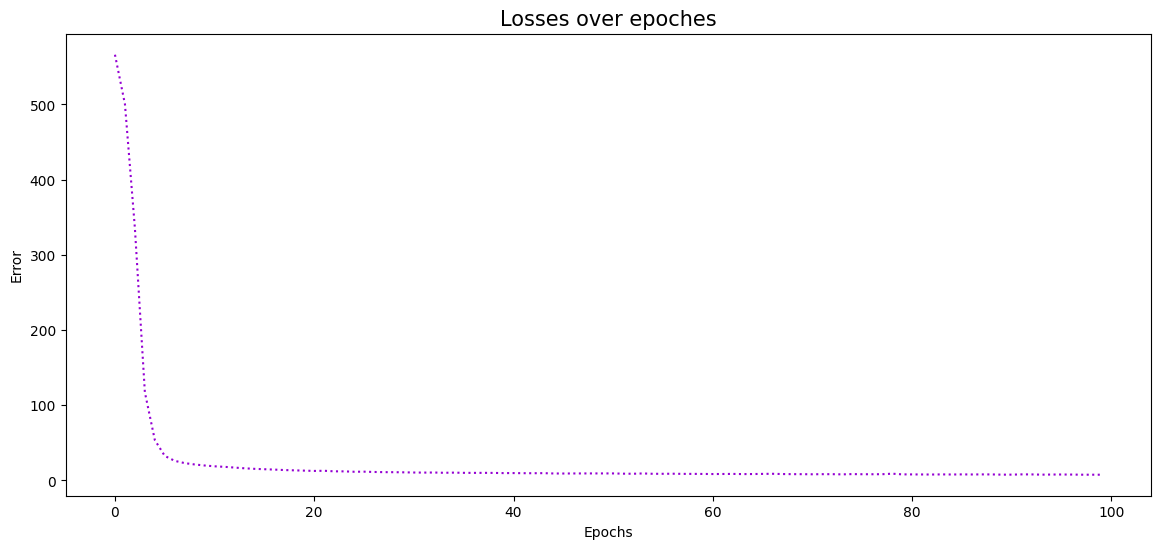

In [20]:
# 전체 loss 에 대한 변화량 시각화
plt.figure(figsize=(14, 6))
plt.plot(losses[:100], c="darkviolet", linestyle=":")

plt.title("Losses over epoches", fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()